In [225]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [226]:
df = pd.read_csv('data/cleaned_all_transactions.csv').iloc[:, 1:]
df.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,state,amount_cleaned
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC,8000.5
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC,8000.5
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC,32500.5
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC,32500.5
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,CA,8000.5


In [227]:
df['owner'] = df['owner'].replace({'--': np.nan})
df['disclosure_date'] = pd.to_datetime(df['disclosure_date'], errors = 'coerce')
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors = 'coerce')
df['non_disclosure_period(days)'] = (df['disclosure_date'] - df['transaction_date']).dt.days
df = df.replace({np.NaN:'missing'})
df = df[df['non_disclosure_period(days)']!='missing']
df.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,state,amount_cleaned,non_disclosure_period(days)
0,2021,2021-10-04 00:00:00,2021-09-27 00:00:00,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC,8000.5,7.0
1,2021,2021-10-04 00:00:00,2021-09-13 00:00:00,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC,8000.5,21.0
2,2021,2021-10-04 00:00:00,2021-09-10 00:00:00,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC,32500.5,24.0
3,2021,2021-10-04 00:00:00,2021-09-28 00:00:00,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC,32500.5,6.0
4,2021,2021-10-04 00:00:00,2021-09-17 00:00:00,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,CA,8000.5,17.0


In [228]:
# df.to_csv('data/no_missing_transactions.csv', index=False)

In [229]:
# df.to_csv('data/cleaned_transactions.csv', index=False)

In [230]:
X = df[['owner', 'type', 'state', 'amount_cleaned', 'non_disclosure_period(days)']]
y = df['cap_gains_over_200_usd']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [231]:
preproc = ColumnTransformer(
    transformers = [
        ('ohe', OneHotEncoder(drop='first'), ['owner', 'type', 'state']),
        ('std', StandardScaler(), ['amount_cleaned', 'non_disclosure_period(days)'])
    ],
    remainder='drop'
)

In [232]:
pl = Pipeline([
    ('prepocessor', preproc),
    ('dec-tree', RandomForestClassifier(criterion='entropy', max_depth=5,min_samples_split=2, n_estimators=70))
    # ('dec-tree', RandomForestClassifier())
])
pl.fit(X_train, y_train)

pred_train = pl.predict(X_train)
pred_train

array([False, False, False, ..., False, False, False])

In [233]:
pred_test = pl.predict(X_test)
pred_test

array([False, False, False, ..., False, False, False])

In [234]:
pl.score(X_train, y_train)

0.9473452496257815

In [235]:
pl.score(X_test, y_test)

0.9454225352112676

In [236]:
y_pred = pl.predict(X_test)

In [237]:
metrics.accuracy_score(y_test, y_pred)

0.9454225352112676

In [238]:
metrics.precision_score(y_test, y_pred)

0.9387755102040817

In [239]:
metrics.recall_score(y_test, y_pred)

0.23232323232323232

In [164]:
hyperparameters = {
    'dec-tree__n_estimators': np.arange(10, 100, 20),
    'dec-tree__criterion': ['gini', 'entropy'],
    'dec-tree__max_depth': [2,3,4,5],
    'dec-tree__min_samples_split': [1,2,5]
}

In [176]:
searcher = GridSearchCV(pl, param_grid = hyperparameters, cv=5, scoring='precision')
searcher.fit(X_train, y_train)
searcher.best_params_

{'dec-tree__criterion': 'entropy',
 'dec-tree__max_depth': 5,
 'dec-tree__min_samples_split': 2,
 'dec-tree__n_estimators': 70}

In [240]:
# Training accuracy
searcher.score(X_train, y_train)

0.9398907103825137

In [241]:
# Testing accuracy
searcher.score(X_test, y_test)

0.9574468085106383

In [242]:
results = X_test
results['prediction'] = y_pred
results['cap_gains_over_200_usd'] = y_test
results['is_CA'] = (results.state == 'CA').replace({True: 'cali', False: 'non_cali'})
results.head()


,owner,type,state,amount_cleaned,non_disclosure_period(days),prediction,cap_gains_over_200_usd,is_CA
8916,missing,purchase,FL,8000.5,363.0,False,False,non_cali
7632,joint,sale_full,NJ,8000.5,21.0,False,False,non_cali
1267,missing,sale_full,PA,32500.5,41.0,False,True,non_cali
9271,missing,sale_full,GA,32500.5,27.0,False,True,non_cali
10708,missing,purchase,VA,8000.5,11.0,False,False,non_cali


In [243]:
results.groupby('is_CA')['prediction'].mean().to_frame()

,prediction
is_CA,
cali,0.000000
non_cali,0.020666


In [250]:
(
    results
    .groupby('is_CA')
    .apply(lambda x: metrics.precision_score(x['cap_gains_over_200_usd'], x['prediction']))
    .rename('precision')
    .to_frame()
)


,precision
is_CA,
cali,0.000000
non_cali,0.938776


In [246]:
obs = results.groupby('is_CA').apply(lambda x: metrics.precision_score(x['cap_gains_over_200_usd'], x['prediction'])).diff().iloc[-1]
obs

0.9387755102040817

In [247]:
diff_in_prec = []
for _ in range(1000):
    s = (
        results[['is_CA', 'prediction', 'cap_gains_over_200_usd']]
        .assign(is_CA=results.is_CA.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('is_CA')
        .apply(lambda x: metrics.precision_score(x['cap_gains_over_200_usd'], x['prediction']))
        .diff()
        .iloc[-1]
    )
    
    diff_in_prec.append(s)

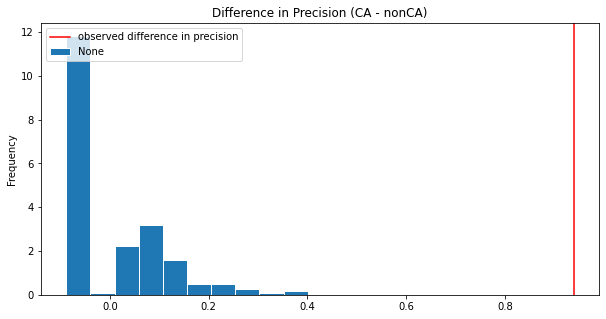

In [248]:
plt.figure(figsize=(10, 5))
pd.Series(diff_in_prec).plot(kind='hist', ec='w', density=True, bins=15, title='Difference in Precision (CA - nonCA)')
plt.axvline(x=obs, color='red', label='observed difference in precision')
plt.legend(loc='upper left');

In [258]:
p_val = (obs <= diff_in_prec).mean()
p_val

0.0